<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/3%20-%20Economics/6.439%20-%20Problem%20Set%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 3 - Statistics, Computation and Applications

(c) Felipe del Canto, October 2021
***
***

# Part 0 (Execute first!)

In [150]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS3_data.zip

# Unzip
!unzip -o PS3_data.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import datetime
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import statsmodels.api         as sm
import statsmodels.formula.api as smf

In [151]:
def fit_npoly_trend(data=None, dep='', n=1, predict=False, residuals=False, sufix='', verbose=True):
  # Create necessary variables
  variables_model = ['t' + f'_{i:d}'*(i>1) for i in range(1,n+1)]

  for pow,var in enumerate(variables_model):
    if pow+1 == 1:
      data[var] = data.index + 1.0
    
    else:
      data[var] = data['t']**(pow+1)
  
  # Write model and fit it (default includes constant)
  formula = dep + ' ~ ' + '+'.join(variables_model)
  ols = smf.ols(formula=formula, data=data, missing='drop', hasconst=False).fit()

  # Print results
  if verbose:
    print(ols.summary())

  # Predict variable and residuals
  if predict or residuals:
    predict_from_model(data, dep, ols, sufix, store_predict=predict, residuals=residuals)
  
  return ols

In [152]:
def predict_from_model(data, dep, model, sufix, store_predict=True, residuals=False):
  # Define predicted variable name
  pred_var = dep + '_pred' + sufix

  # Predict for values that are not nan
  data.loc[data[dep].notna(), pred_var] = model.predict()

  # If residuals are required, define a new variable
  if residuals:
    data['res'+sufix] = data[dep] - data[pred_var]

  # If not storing the predicted variable, remove it
  if not store_predict:
    data.drop(pred_var, inplace=True)

  return None

In [153]:
def obtain_dates_and_lims(dates, offset):
  # Obtain DateIndex object
  dates = pd.to_datetime(dates)
  
  # Compute min and max using Offsets pandas objects
  date_min = dates[0]  - offset * pd.offsets.YearBegin(1)
  date_max = dates[-1] + offset * pd.offsets.YearBegin(1)

  lims = [date_min, date_max]

  return dates, lims

# Part 1

## Problem 3.1: The Manua Loa $\text{CO}_2$ concentration.

In [154]:
# Write column names
old_colnames = ['year', 'month', 'date_excel', 'date_num', 'co2',
            'co2_season_adj', # season adjusted using substracting 4-harmonic fit
            'co2_fit',        # cubic spline
            'co2_season_adj_fit', # fit substracting season adj
            'co2_filled',         # filled with co2_fit
            'co2_season_adj_filled'] # season adjusted column filled with co2_season_adj_fit

# Load data
co2_data = pd.read_csv('CO2Data.csv',index_col=False, names=old_colnames, skiprows=59)

# Replace missing values with NANs
missing_value_code = -99.99
co2_data.replace(to_replace = missing_value_code, value=pd.NA, inplace=True)

# Create date variable
co2_data['date'] = co2_data['year'].apply(str) + "/" + co2_data['month']. apply(str) + "/15"
co2_data['date'] = pd.to_datetime(co2_data['date'], format="%Y/%m/%d")

# Delete date_excel and date_num columns
colnames = ['date'] + [colname for colname in old_colnames if colname.find("date") == -1]
co2_data = co2_data[colnames]

In [155]:
co2_data.describe(include='all', datetime_is_numeric=True)

,date,year,month,co2,co2_season_adj,co2_fit,co2_season_adj_fit,co2_filled,co2_season_adj_filled
count,706,706.0000,706.0000,698.0000,698.0000,703.0000,703.0000,703.0000,703.0000
mean,1987-07-31 06:21:24.985835712,1987.0822,6.5142,352.0019,351.9928,351.7580,351.7441,351.7632,351.7493
min,1958-03-15 00:00:00,1958.0000,1.0000,313.2100,314.4200,312.4400,314.9000,312.4400,314.4200
25%,1972-11-22 12:00:00,1972.0000,4.0000,328.4825,328.9275,328.3250,328.1950,328.1100,328.2800
50%,1987-07-30 12:00:00,1987.0000,7.0000,349.5300,349.5400,349.3000,348.8500,348.9600,348.7600
75%,2002-04-07 06:00:00,2002.0000,9.7500,372.7625,372.2725,372.2400,372.0850,372.2800,372.1500
max,2016-12-15 00:00:00,2016.0000,12.0000,407.6500,404.7300,407.2300,404.6200,407.6500,404.7300
std,NaN,16.9953,3.4490,25.9608,25.8717,26.0202,25.9373,26.0232,25.9403


### (a)

#### Fit linear model and predict, with residuals 

In [156]:
fit_kwargs_a = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 1,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_a'}

ols_a = fit_npoly_trend(**fit_kwargs_a)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.885e+06
Date:                Wed, 20 Oct 2021   Prob (F-statistic):                        0.00
Time:                        14:36:05   Log-Likelihood:                         -1936.2
No. Observations:                 698   AIC:                                      3876.
Df Residuals:                     696   BIC:                                      3885.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Plot fit

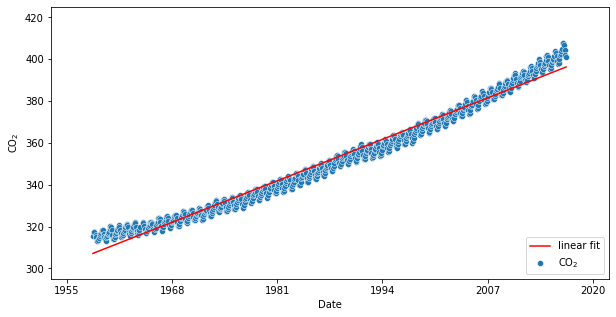

In [157]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred_a', label='linear fit', color = 'red', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

#### Plot residuals

In [158]:
co2_data['res_a'].describe()

count   698.0000
mean     -0.0000
std       3.8793
min      -7.5585
25%      -2.7610
50%      -0.3895
75%       2.3948
max      11.9056
Name: res_a, dtype: float64

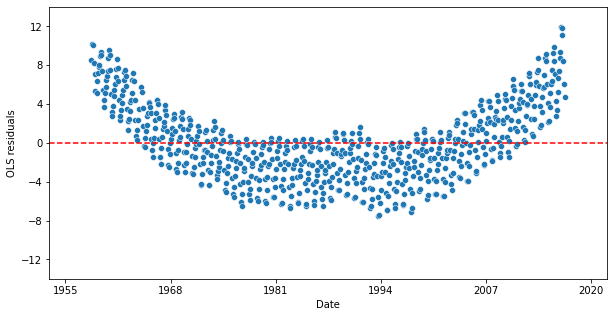

In [159]:
# Axis offsets
offset = (2, 2)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and horizontal axis line
sns.scatterplot(data=co2_data, x='date', y='res_a', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [-12 + 4*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel("OLS residuals")

# Show figure
fig.show()

#### Compute and plot ACF

In [160]:
acf_kwargs_a = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_a = sm.tsa.acf(co2_data['res_a'], **acf_kwargs_a)

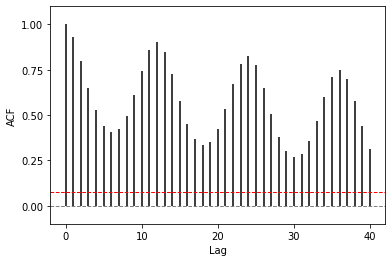

In [161]:
# Axis offset
offset = (None, 0.1)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_a['nlags']+1)]
plt.vlines(lags, 0, corr_a)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [0.25*k for k in range(5)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

### (b)

#### Fit quadratic model and predict, with residuals 

In [162]:
fit_kwargs_b = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 2,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_b'}

ols_b = fit_npoly_trend(**fit_kwargs_b)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.910e+06
Date:                Wed, 20 Oct 2021   Prob (F-statistic):                        0.00
Time:                        14:36:06   Log-Likelihood:                         -1543.9
No. Observations:                 698   AIC:                                      3094.
Df Residuals:                     695   BIC:                                      3107.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Plot fit

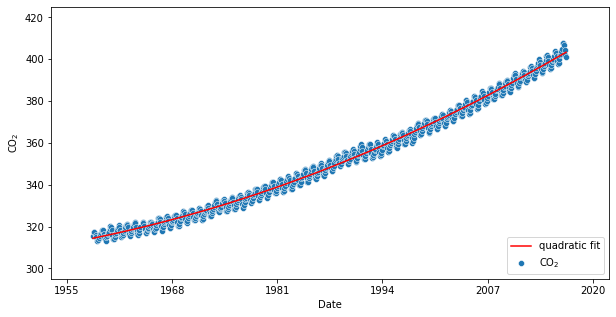

In [163]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred_b', label='quadratic fit', color = 'red', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

#### Plot residuals

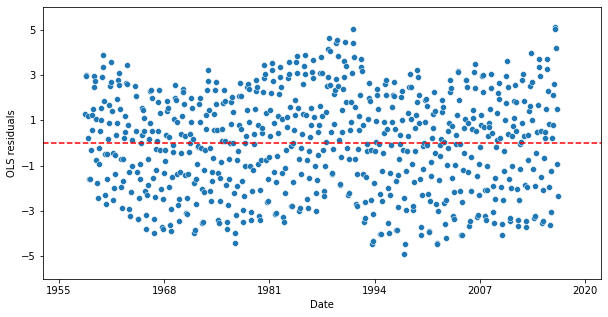

In [164]:
# Axis offsets
offset = (2, 1)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='res_b', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [-5 + 2*k for k in range(6)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel("OLS residuals")

# Show figure
fig.show()

#### Compute and plot ACF

In [165]:
acf_kwargs_b = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_b = sm.tsa.acf(co2_data['res_b'], **acf_kwargs_b)

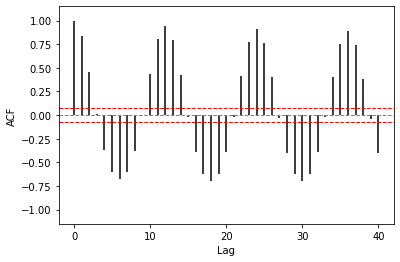

In [166]:
# Axis offset
offset = (None, 0.15)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_b['nlags']+1)]
plt.vlines(lags, 0, corr_b)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')
plt.axhline(y=-z_alpha, linestyle='--', linewidth=1, color = 'red')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [-1 + 0.25*k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

### (c)

#### Fit quartic model and predict, with residuals 

In [167]:
fit_kwargs_c = {'data'      : co2_data,
                'dep'       : 'co2',
                'n'         : 4,
                'predict'   : True,
                'residuals' : True,
                'sufix'     : '_c'}

ols_c = fit_npoly_trend(**fit_kwargs_c)

                                 OLS Regression Results                                
Dep. Variable:                    co2   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.685e+06
Date:                Wed, 20 Oct 2021   Prob (F-statistic):                        0.00
Time:                        14:36:07   Log-Likelihood:                         -1529.4
No. Observations:                 698   AIC:                                      3069.
Df Residuals:                     693   BIC:                                      3092.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Plot fit

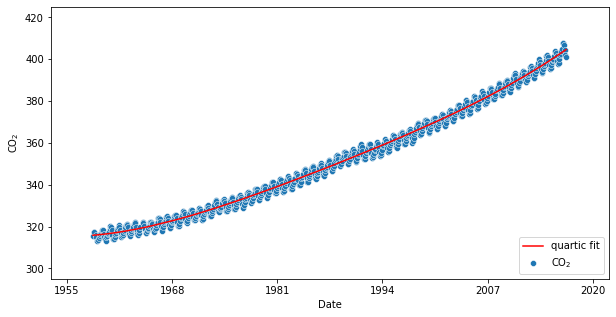

In [168]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='co2', label=r'CO$_2$', ax=ax)
sns.lineplot(data=co2_data, x='date', y='co2_pred_c', label='quartic fit', color = 'red', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$")

# Set legend location
plt.legend(loc='lower right')

# Show figure
fig.show()

#### Plot residuals

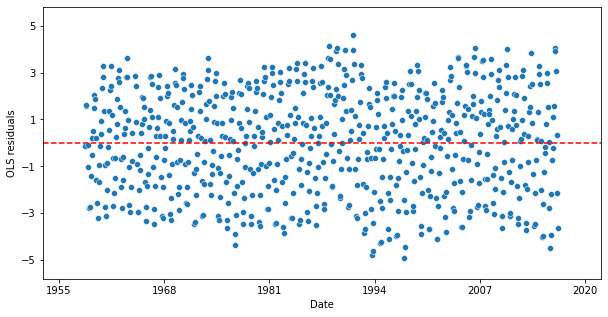

In [169]:
# Axis offsets
offset = (2, 0.8)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='res_c', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [-5 + 2*k for k in range(6)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel("OLS residuals")

# Show figure
fig.show()

#### Compute and plot ACF

In [170]:
acf_kwargs_c = {'nlags'   : 40,
                'missing' : 'conservative',
                'fft'     : True}

corr_c = sm.tsa.acf(co2_data['res_c'], **acf_kwargs_c)

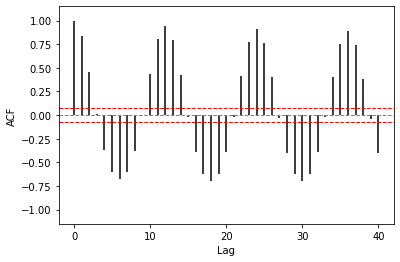

In [171]:
# Axis offset
offset = (None, 0.15)

# Initialize figure
fig, ax = plt.subplots()

# Set number of (not NaN) observations and upper side of CI around 0.
N = co2_data['co2'].notna().sum()
z_alpha = 1.96/np.sqrt(N)

# Define xvariable and plot ACF
lags = [i for i in range(acf_kwargs_c['nlags']+1)]
plt.vlines(lags, 0, corr_b)

# Draw x axis and upper line of CI around 0 
plt.axhline(y=z_alpha, linestyle='--', linewidth=1, color = 'red')
l = plt.axhline(y=0, linestyle='--', linewidth = 1, color = 'gray')
plt.axhline(y=-z_alpha, linestyle='--', linewidth=1, color = 'red')

# Set xticks and yticks
xticks = [10*k for k in range(5)]
plt.xticks(xticks)

yticks = [-1 + 0.25*k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim([yticks[0] - offset[1], yticks[-1] + offset[1]])

# Set xlabel and ylabel
plt.xlabel("Lag")
plt.ylabel("ACF")

# Show figure
fig.show()

### (d)

#### Compute monthly average of residuals for quadratic fit

In [172]:
# Compute month averages of the residuals and assign them to a new column 
p_i = co2_data['res_b'].groupby(co2_data['month']).mean()
co2_data['period_b'] = co2_data['res_b'].groupby(co2_data['month']).transform('mean')

#### Plot the averages

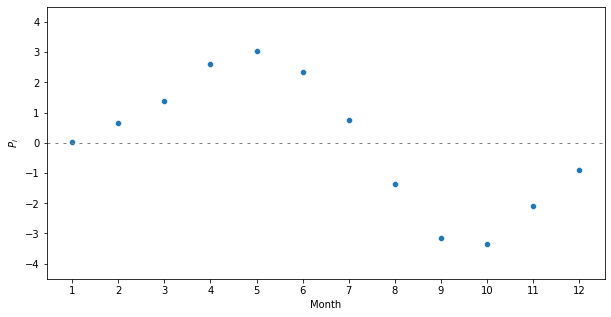

In [173]:
# Axis offsets
offset = (None,0.5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
months = [i for i in range(1,13)]
sns.scatterplot(x=months, y=p_i, ax=ax)
l = plt.axhline(linestyle='--', linewidth = 1, color = 'gray')
l.set_dashes([3,5])

# Set xticks and yticks
xticks = months
plt.xticks(xticks)

yticks = [-4 + k for k in range(9)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Month")
plt.ylabel(r"$P_i$")

# Show figure
fig.show()

#### Adjust for seasonality

In [174]:
# Remove seasonal component (monthly averages of residuals)
co2_data['co2_season_adj_b'] = co2_data['co2'] - co2_data['period_b']

#### Plot the adjusted series

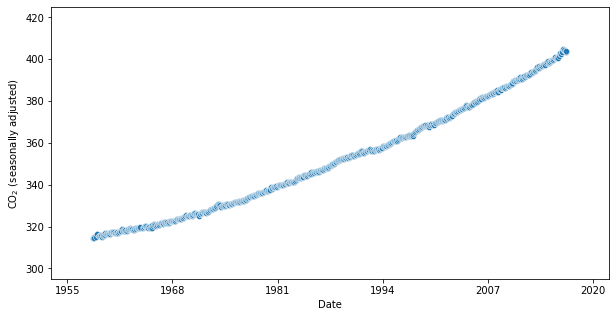

In [175]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='co2_season_adj_b', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$ (seasonally adjusted)")

# Show figure
fig.show()

#### Compare with provided seasonally adjusted series

In [176]:
# Compare with provided seasonally adjusted series
co2_data['diff_season_adj'] = co2_data['co2_season_adj'] - co2_data['co2_season_adj_b']
co2_data['diff_season_adj_rel'] = co2_data['diff_season_adj']/co2_data['co2_season_adj'] * 100
co2_data[['diff_season_adj', 'diff_season_adj_rel']].describe()

,diff_season_adj,diff_season_adj_rel
count,698.0000,698.0000
mean,-0.0092,-0.0026
std,0.1264,0.0362
min,-0.3582,-0.1133
25%,-0.0814,-0.0244
50%,-0.0040,-0.0013
75%,0.0582,0.0168
max,0.3446,0.0979


### (e)

#### Compute the seasonally adjusted fit

In [177]:
co2_data['co2_season_adj_fit_b'] = co2_data['co2_pred_b'] + co2_data['period_b']

#### Plot the seasonally adjusted fit

In [178]:
pd.to_datetime(xticks)[0]- pd.offsets.MonthBegin(1)

Timestamp('1954-12-01 00:00:00')

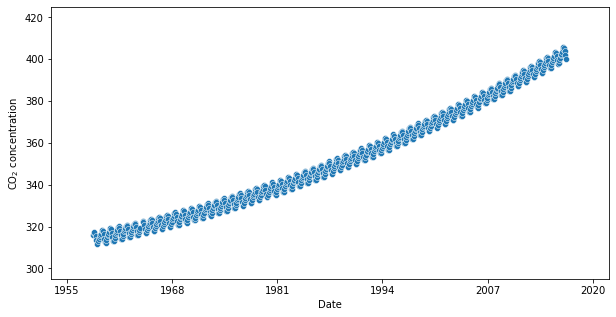

In [179]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and fit
sns.scatterplot(data=co2_data, x='date', y='co2_season_adj_fit_b', ax=ax)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set yticks
yticks = [300 + 20*k for k in range(7)]
plt.yticks(yticks)
ax.set_ylim([yticks[0]-offset[1], yticks[-1]+offset[1]])

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$ concentration")

# Show figure
fig.show()

#### Compute the difference between the seasonally adjusted fit and the orinal series

In [180]:
# Compare with original series
co2_data['diff_season_adj_fit'] = co2_data['co2'] - co2_data['co2_season_adj_fit']
co2_data['diff_season_adj_fit_rel'] = co2_data['diff_season_adj_fit']/co2_data['co2'] * 100
co2_data[['diff_season_adj_fit', 'diff_season_adj_fit_rel']].describe()

,diff_season_adj_fit,diff_season_adj_fit_rel
count,698.0000,698.0000
mean,0.0144,0.0004
std,2.1140,0.6007
min,-4.0400,-1.1105
25%,-1.7650,-0.5008
50%,0.3400,0.0996
75%,1.8675,0.5328
max,3.9600,1.0575


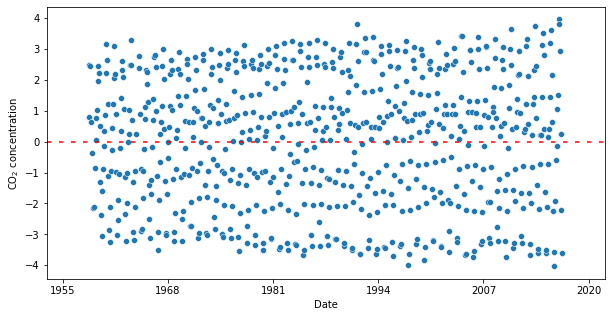

In [181]:
# Axis offsets
offset = (2,5)

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

# Draw scatterplot and horizontal x axis line
sns.scatterplot(data=co2_data, x='date', y='diff_season_adj_fit', ax=ax)
l = plt.axhline(linestyle='--', color = 'red')
l.set_dashes([3,5])

# Set xticks and yticks
xticks = [f'{1955+10*k:d}' for k in range(7)]
plt.xticks(pd.to_datetime(xticks), xticks)

# Set xticks
xticks = [f'{1955+13*k:d}' for k in range(6)]
date_ticks, x_lims = obtain_dates_and_lims(xticks, offset[0])
plt.xticks(pd.to_datetime(xticks), xticks)
ax.set_xlim(x_lims)

# Set xlabel and ylabel
plt.xlabel("Date")
plt.ylabel(r"CO$_2$ concentration")

# Show figure
fig.show()

## Problem 3.1: BPP Data Analysis

### (a)

### (b)

### (c)

### (d)

### (e)

### (f)